### Randomizing an adjacency

Algorithms to randomize an adjacency matrix of a binary undirected network preserving each node degree.

#### For weighed networks, you need to preserve strengths not just degrees, so:
- Take a random pair of links ij and kl 
- Consider the strengths w_ij, w_kl as well as w_il and w_kj 
- Set w_il to a new value equal to old w_ij and w_ij to a new value equal to old w_il 
- Set w_kj to a new value equal to old w_kl and w_kl to a new value equal to old w_kj 
- Do the same for the pair ji and lk, since the coherence networks must be symmetric 


In [1]:
%matplotlib inline
import ctypes
import numpy             as np
import numba             as nb
import matplotlib.pyplot as plt
from   tqdm              import tqdm

In [2]:
_ra = ctypes.CDLL('./libwadj.so')

In [3]:
_ra.randomize_adjacency_wei.argtypes = (ctypes.c_int, ctypes.c_int, 
                                        ctypes.POINTER(ctypes.POINTER(ctypes.c_float)), 
                                        ctypes.POINTER(ctypes.c_int))
_ra.randomize_adjacency_wei.restype  = ctypes.POINTER(ctypes.POINTER(ctypes.c_float))

### Defining wrapper for C function in python

In [4]:
def randomize_adjacency_wei(A, n_rewires, seed):
    global _ra
    A_copy  = np.array(A, dtype=np.float32).copy()
    # Number of nodes
    n_nodes = A_copy.shape[0]
    # Getting edges with connection
    x_s,x_t = np.tril_indices_from(A_copy, k=-1)
    w       = A_copy[x_s,x_t]
    non_zero= np.where(w>0)
    x_s,x_t = x_s[non_zero],x_t[non_zero]
    # Number of edges
    n_edges = len(x_s)
    
    # To convert array with sources and targets
    array_type  = (ctypes.c_int * n_edges)
    
    # Converting matrix to pointer to pointer
    UF32Ptr    = ctypes.POINTER(ctypes.c_float)
    UF32PtrPtr = ctypes.POINTER(UF32Ptr)

    ct_arr     = np.ctypeslib.as_ctypes(A_copy)
    UF32PtrArr = UF32Ptr * ct_arr._length_
    ct_ptr_A   = ctypes.cast(UF32PtrArr(*(ctypes.cast(row, UF32Ptr) for row in ct_arr)), UF32PtrPtr)
    
    # Call function
    Arn = _ra.randomize_adjacency_wei(ctypes.c_int(n_rewires), ctypes.c_int(n_nodes), ct_ptr_A, ctypes.c_int(seed))
    
    Arn_py = np.array([[Arn[i][j] for j in range(n_nodes)] for i in range(n_nodes)], dtype=Arn._type_._type_._type_)
    return Arn_py

### Python implementation

In [5]:
#@nb.jit(nopython=True)
def _randomize_adjacency_wei(A, n_swaps, seed):
    
    np.random.seed(seed)
    
    # Number of nodes
    n_nodes = A.shape[0]
    # Copy the adj. matrix
    Arnd    = A.copy()
    
    # Choose edges that will be swaped
    edges = np.random.choice(n_nodes, size=(4, n_swaps), replace=True).T
    
    #itr = range(n_swaps)
    #for it in tqdm(itr) if verbose else itr:
    it = 0
    for it in range(n_swaps):
        i,j,k,l = edges[it,:]
        if len(np.unique([i,j,k,l]))<4:
            continue
        else:
            # Old values of weigths
            w_ij,w_il,w_kj,w_kl=Arnd[i,j],Arnd[i,l],Arnd[k,j],Arnd[k,l]
            # Swaping edges
            Arnd[i,j]=Arnd[j,i]=w_il
            Arnd[k,l]=Arnd[l,k]=w_kj
            Arnd[i,l]=Arnd[l,i]=w_ij
            Arnd[k,j]=Arnd[j,k]=w_kl
    return Arnd

#### Load an adjacency matrix

In [6]:
A = np.loadtxt('adj.txt',delimiter=' ', dtype=int)

In [7]:
A = A * np.random.randint(0,10,A.shape)
A = (A+A.T)/2
np.fill_diagonal(A,1)

#### C

In [8]:
Arn    =  randomize_adjacency_wei(A, 10000, 0)

#### Python

In [9]:
Arn_py = _randomize_adjacency_wei(A, 10000, 100)

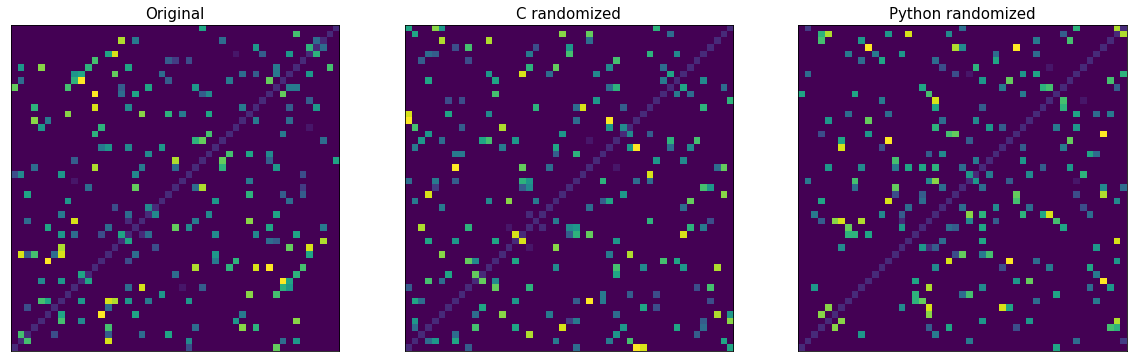

In [10]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(A,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('Original', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(Arn,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('C randomized', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(Arn_py,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('Python randomized', fontsize=15)
plt.xticks([])
plt.yticks([]);

In [11]:
d1=A.sum(-1)
d2=Arn_py.sum(-1)
d3=Arn_py.sum(-1)
print('Average strength of the network:')
print('---------------------------------------')
print(f'Original          = {d1.mean()}')
print(f'C randomized      = {d2.mean()}')
print(f'Python randomized = {d3.mean()}')

Average strength of the network:
---------------------------------------
Original          = 21.346938775510203
C randomized      = 21.346938775510203
Python randomized = 21.346938775510203


#### Test if average network strength is maintained for different seeds

In [12]:
n_rewires  = 10000
seeds      = np.linspace(0, 1000,20,dtype=int)
d1, d2, d3 = [],[],[]

for seed in tqdm( seeds ):
    d1 += [A.sum(-1).mean()]
    d2 += [randomize_adjacency_wei(A,  n_rewires, seed).sum(-1).mean()]
    d3 += [_randomize_adjacency_wei(A, n_rewires, seed).sum(-1).mean()]
d1 = np.squeeze(d1).astype(np.float32)
d2 = np.squeeze(d2).astype(np.float32)
d3 = np.squeeze(d3).astype(np.float32)

100%|██████████| 20/20 [00:02<00:00,  9.62it/s]


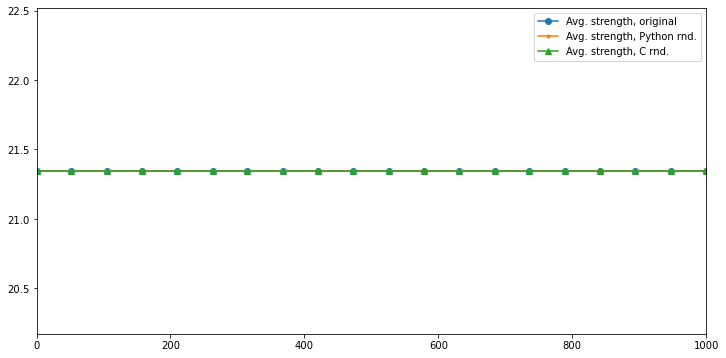

In [13]:
plt.figure(figsize=(12,6))
plt.plot(seeds, d1, label='Avg. strength, original',    marker='o')
plt.plot(seeds, d2, label='Avg. strength, Python rnd.', marker='.')
plt.plot(seeds, d3, label='Avg. strength, C rnd.',      marker='^')
plt.xlim([0,1000])
plt.legend()

#### Check if the degrees were preserved

In [14]:
d_o = A.sum(axis = -1)
d_c = Arn.sum(axis = -1)
d_p = Arn_py.sum(axis = -1)

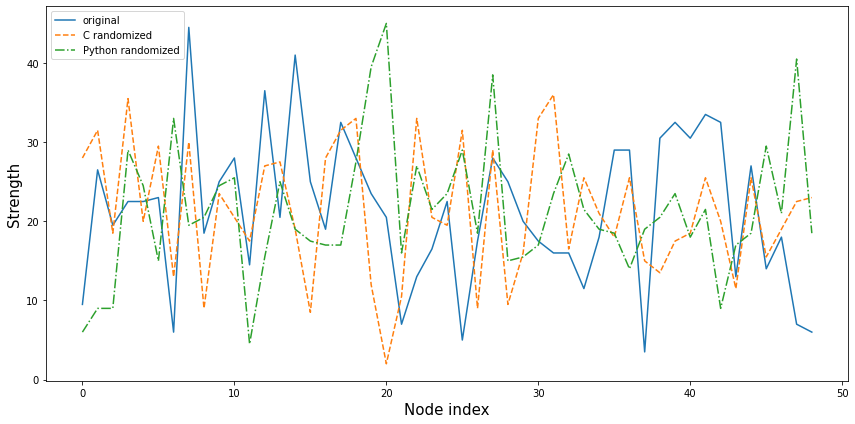

In [15]:
plt.figure(figsize=(12,6))
plt.plot(d_o, label = 'original')
plt.plot(d_c, '--', label = 'C randomized')
plt.plot(d_p, '-.',label = 'Python randomized')
plt.xlabel('Node index', fontsize=15)
plt.ylabel('Strength', fontsize=15)
plt.legend()
plt.tight_layout()

### Comparing perfomance between Python, C and igraph

In [16]:
n_rewires = np.arange(10, 111 * np.log(1/1e-8), 100, dtype=int)
ex_t      = np.zeros([2,2,len(n_rewires)])

In [17]:
plt.figure(figsize=(12,6))
for i in range(n_rewires.shape[0]):
    t1 = %timeit -o randomize_adjacency_wei(A, n_rewires[i], 0)
    ex_t[0,0,i]=t1.average
    ex_t[0,1,i]=t1.stdev
    t2 = %timeit -o _randomize_adjacency_wei(A, n_rewires[i], 0)
    ex_t[1,0,i]=t2.average
    ex_t[1,1,i]=t2.stdev

567 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
122 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
560 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.09 ms ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
570 µs ± 8.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.98 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
572 µs ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.95 ms ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
575 µs ± 5.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.9 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
604 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.93 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
624 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.84 ms ± 79.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops 

<Figure size 864x432 with 0 Axes>

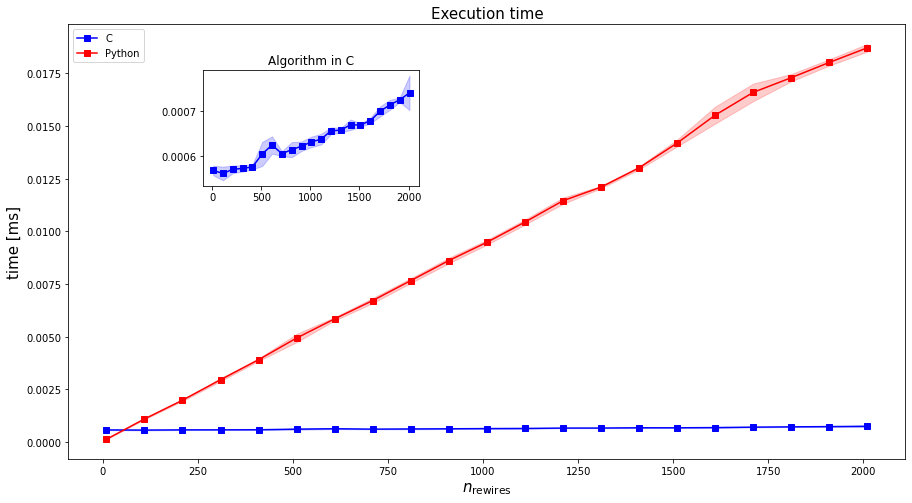

In [18]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(n_rewires, ex_t[0,0], 's-b', label = 'C')
ax1.fill_between(n_rewires, ex_t[0,0]-ex_t[0,1], ex_t[0,0]+ex_t[0,1], color='b', alpha = .2)
#
ax1.plot(n_rewires, ex_t[1,0], 'r-s', label = 'Python')
ax1.fill_between(n_rewires, ex_t[1,0]-ex_t[1,1], ex_t[1,0]+ex_t[1,1], color='r', alpha = .2)
plt.xlabel(r'$n_{\rm rewires}$', fontsize=15)
plt.ylabel('time [ms]', fontsize=15)
plt.title('Execution time', fontsize=15)
plt.legend()
# Inset 
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(n_rewires, ex_t[0,0], 's-b')
plt.title('Algorithm in C')
ax2.fill_between(n_rewires, ex_t[0,0]-ex_t[0,1], ex_t[0,0]+ex_t[0,1], color='b', alpha = .2)